In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

In [3]:
import torch
import torch.nn as nn
import albumentations as A
import numpy as np
import time
import os

"""
ResNet-based Keypoint Estimator
"""
class asdfConfiguration:
    def __init__(self):
        """
        self.temp = {
            'train_data': '/home/sasank/Documents/GitRepos/Sasank_JTML_seg/data/3_2_22_fem/train_3_2_22_fem.csv',
            'val_data': '/home/sasank/Documents/GitRepos/Sasank_JTML_seg/data/3_2_22_fem/val_3_2_22_fem.csv',
            'test_data': '/home/sasank/Documents/GitRepos/Sasank_JTML_seg/data/3_2_22_fem/test_3_2_22_fem.csv'
        }
        """
        self.init = {
            'PROJECT_NAME': 'Keypoint Estimation',
            'MODEL_NAME': 'Tib_64KP',
            'RUN_NAME': time.strftime('%Y-%m-%d-%H-%M-%S'),
            'WANDB_RUN_GROUP': 'Local',
            'FAST_DEV_RUN': False,  # Runs inputted batches (True->1) and disables logging and some callbacks
            'MAX_EPOCHS': 10,
            'MAX_STEPS': -1,    # -1 means it will do all steps and be limited by epochs
            'STRATEGY': None    # This is the training strategy. Should be 'ddp' for multi-GPU (like HPG)
        }
        self.etl = {
            'RAW_DATA_FILE': -1,
            'DATA_DIR': "data",
            # Lol what is this?
            'KEYPOINT_DIRECTORY': "keypoints",
            'KEYPOINT_TXT_FILES': ['tib_KPlabels_16.txt'],
            'VAL_SIZE':  0.2,       # looks sus
            'TEST_SIZE': 0.01,      # I'm not sure these two mean what we think
            #'random_state': np.random.randint(1,50)
            # HHG2TG lol; deterministic to aid reproducibility
            'RANDOM_STATE': 42,

            'CUSTOM_TEST_SET': False,
            'TEST_SET_NAME': '/my/test/set.csv'
        }

        self.dataset = {
            'DATA_NAME': 'Ten_Dogs_64KP',
            'SUBSET_PIXELS': True,
            'IMAGE_HEIGHT': 1024,
            'IMAGE_WIDTH': 1024,
            'MODEL_TYPE': 'tib',        # how should we do this? not clear this is still best...
            'CLASS_LABELS': {0: 'bone', 1: 'background'},
            'NUM_KEY_POINTS': 64,
            'IMG_CHANNELS': 1,      # Is this different from self.module['NUM_IMAGE_CHANNELS']
            'STORE_DATA_RAM': False,
            'IMAGE_THRESHOLD': 0,
            'USE_ALBUMENTATIONS': True,

            # What do these do?
            'NUM_PRINT_IMG' : 1,
            'KP_PLOT_RAD' : 3,

            #'NUM_POINTS' : 128,

            'GAUSSIAN_STDDEV' : 5,
            'GAUSSIAN_AMP' : 1e3,

            'STORE_DATA_RAM' : False,

            'CROP_IMAGES' : False,
            'CROP_MIN_X' : 0.29,
            'CROP_MAX_X' : 0.84,
            'CROP_MIN_Y' : 0.45,
            'CROP_MAX_Y' : 0.95,
            
            'IMAGES_PER_GRID': 1,
            'per_grid_image_count_height' : 1, 
            'per_grid_image_count_width' : 1
        }

        """
        # segmentation_net_module needs to be below dataset because it uses dataset['IMG_CHANNELS']
        self.keypoint_net_module = {
            'NUM_KEY_POINTS': 128,
            'NUM_IMG_CHANNELS': self.dataset['IMG_CHANNELS']
        }
        """

        self.datamodule = {
            'IMAGE_DIRECTORY': '/media/sasank/LinuxStorage/Dropbox (UFL)/Canine Kinematics Data/TPLO_Ten_Dogs_grids/',
            'CKPT_FILE': None,
            'USE_NAIVE_TEST_SET': False,
            'BATCH_SIZE': 2,
            'SHUFFLE': True,        # Only for training; for test and val this is set in the datamodule script to False
            'NUM_WORKERS': 2,
            'PIN_MEMORY': False
            #'SUBSET_PIXELS': True - this is now in dataset
        }


        # hyperparameters for training
        self.hparams = {
            'LOAD_FROM_CHECKPOINT': False,
            'learning_rate': 1e-3
        }

        #self.transform = None
        self.transform = \
        A.Compose([
            # Let's do only rigid transformations for now
            A.HorizontalFlip(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.2),
            A.Transpose(p=0.2),
        ],
        keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
        p=0.0)

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from skimage import io
import cv2
import random

import pytorch_lightning as pl
import wandb

from loss import kp_loss



class asdfKeypointDataset(torch.utils.data.Dataset):

    def __init__(self, config, evaluation_type, transform=None):
        """
        Args:
            config (config): Dictionary of vital constants about data.
            store_data_ram (boolean): Taken from config.
            evaluation_type (string): Dataset evaluation type (must be 'training', 'validation', or 'test')
            num_points (int): Taken from config.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Create local copies of the arguments
        self.config = config
        self.num_points = self.config.dataset['NUM_KEY_POINTS']
        self.transform = self.config.transform
        
        # Check that evaluation_type is valid and then store
        if evaluation_type in ['train', 'val', 'test', 'naive']:
            self.evaluation_type = evaluation_type
        else:
            raise Exception('Incorrect evaluation type! Must be either \'train\', \'val\', \'test\', or \'naive\'.')

        # Load the data from the big_data CSV file into a pandas dataframe
        #self.data = pd.read_csv(os.path.join(self.config.etl['DATA_DIR'], self.config.dataset['DATA_NAME'], self.evaluation_type + '_' + self.config.dataset['DATA_NAME'] + '.csv'))
        self.data = pd.read_csv('/home/sasank/Documents/GitRepos/Stifle-Keypoints/data/proc_64KP_data.csv')

    def __len__(self):
        return len(self.data) - 1   # Subtract 1 because the first row is the column names
    
    def __getitem__(self, idx):
        idx += 1    # Add 1 because the first row is the column names

        # Get the row of the dataframe
        row = self.data.iloc[idx]

        # Get the image name
        image_name = row['Image address']

        # Get the image
        image = io.imread(os.path.join(self.config.datamodule['IMAGE_DIRECTORY'], image_name))
        full_image = image             # Save full image (no subset_pixels) for visualization

        # Get the keypoint labels and segmentation labels
        if self.config.dataset['MODEL_TYPE'] == 'fem':
            kp_label = row['Femur 2D KP points']
            seg_label = io.imread(os.path.join(self.config.datamodule['IMAGE_DIRECTORY'], row['Fem label address']))
        elif self.config.dataset['MODEL_TYPE'] == 'tib':
            kp_label = row['Tibia 2D KP points']
            seg_label = io.imread(os.path.join(self.config.datamodule['IMAGE_DIRECTORY'], row['Tib label address']))
        else:
            raise Exception('Incorrect model type! Must be either \'fem\' or \'tib\'.')

        kp_label = kp_label[2:-2]
        kp_label = kp_label.split(']\n [')
        kp_label = [np.array([float(x) for x in list(filter(None, kp.split(' ')))]) for kp in kp_label]
        kp_label = np.array(kp_label)
        kp_label[:, 1] = 1 - kp_label[:, 1]         # ! New kp_label preprocessing
        kp_label = kp_label * 1024
        
        # * Transformations
        # Albumenations
        print('kp_label: ', kp_label)
        image_no_transform = image
        if self.transform and self.config.dataset['USE_ALBUMENTATIONS'] == True:
            transformed = self.transform(image=image, mask=seg_label, keypoints=kp_label)
            image, seg_label, kp_label = transformed['image'], transformed['mask'], transformed['keypoints']
        print('transformed kp_label: ', kp_label)

        # * Subset Pixels
        full_image = image             # Save full image (no subset_pixels) for visualization
        if self.config.dataset['SUBSET_PIXELS'] == True:
            label_dst = np.zeros_like(seg_label)
            label_normed = cv2.normalize(seg_label, label_dst, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX)
            seg_label = label_normed

            # Make a set of kernels such as 10x10, 20x20, 30x30, 40x40, 50x50, 60x60, 70x70, 80x80, 90x90, 100x100
            kernel_set = [(10,10), (20,20), (30,30), (40,40), (50,50), (60,60)]
            kernel = np.ones(random.choice(kernel_set), np.uint8)
            #kernel = np.ones((10,10), np.uint8)
            label_dilated = cv2.dilate(seg_label, kernel, iterations = 5)
            image_subsetted = cv2.multiply(label_dilated, image)
            image = image_subsetted

        # * Convert to tensors
        image = torch.FloatTensor(image[None, :, :]) # Store as byte (to save space) then convert when called in __getitem__. - What. What does this mean?
        full_image = torch.FloatTensor(full_image[None, :, :]) # Store as byte (to save space) then convert when called in __getitem__
        seg_label = torch.FloatTensor(seg_label[None, :, :])
        kp_label = torch.FloatTensor(kp_label)          # kp_label is of shape (num_keypoints, 2)
        assert kp_label.shape == (self.num_points, 2), "Keypoint label shape is incorrect!"
        #print("kp_label.shape:")
        #print(kp_label.shape)

        # * Create a dictionary of the sample
        sample = {'image': image,
                    'img_name': image_name,
                    'kp_label': kp_label,
                    'seg_label': seg_label,
                    'full_image': full_image,
                    'image_no_transform': image_no_transform}

        # * Return the sample
        return sample

In [11]:
#from temp_config import Configuration
#from KeypointDataset import KeypointDataset
import matplotlib.pyplot as plt
import albumentations as A

config = asdfConfiguration()
dataset = asdfKeypointDataset(config, 'train')

image number: 0
kp_label:  [[ 302.857216    543.516672  ]
 [ 447.809536    752.321536  ]
 [ 303.717376    627.33312   ]
 [ 509.586432    867.521536  ]
 [ 365.005824    599.768064  ]
 [ 453.229568    777.44128   ]
 [ 410.171392    686.114816  ]
 [ 610.978816   1054.7421184 ]
 [ 365.964288    549.262336  ]
 [ 405.163008    767.643648  ]
 [ 376.655872    570.447872  ]
 [ 560.336896    986.5101312 ]
 [ 361.946112    549.92384   ]
 [ 520.583168    884.800512  ]
 [ 369.901568    670.850048  ]
 [ 591.668224   1027.00895232]
 [ 290.338816    549.66272   ]
 [ 464.063488    791.012352  ]
 [ 316.002304    581.914624  ]
 [ 541.448192    947.7414912 ]
 [ 329.317376    649.691136  ]
 [ 488.795136    856.832     ]
 [ 431.823872    717.986816  ]
 [ 552.13056    1059.5751936 ]
 [ 411.953152    551.928832  ]
 [ 403.407872    692.589568  ]
 [ 343.750656    692.553728  ]
 [ 566.127616    966.2296064 ]
 [ 383.558656    627.54816   ]
 [ 501.433344    921.302016  ]
 [ 399.71328     727.81824   ]
 [ 623.92627

KeyboardInterrupt: 

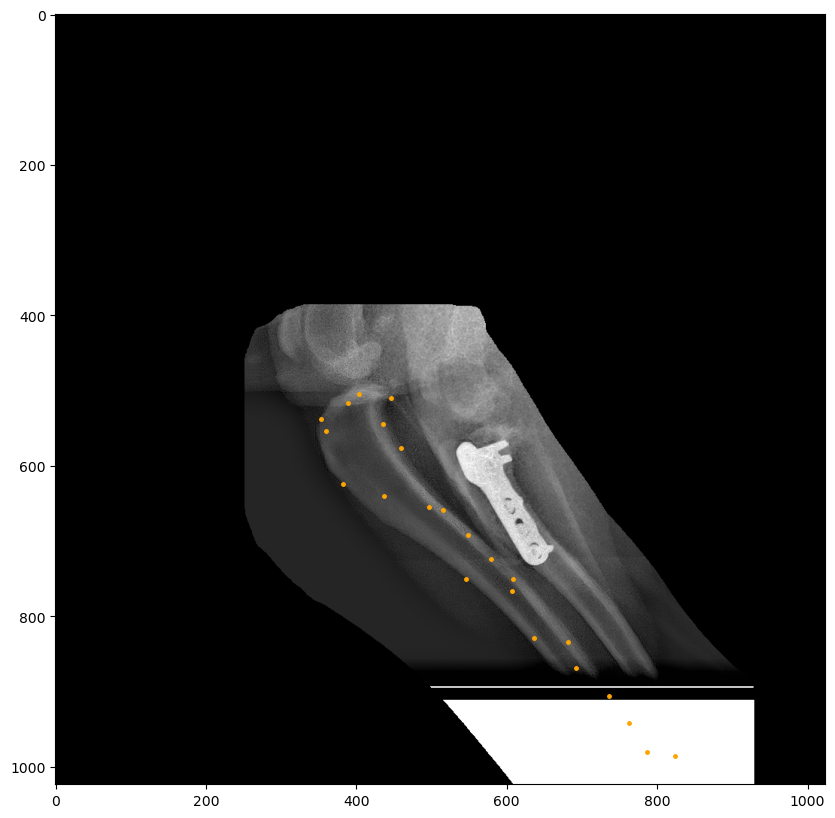

In [12]:
PRINT_DIR = '/media/sasank/LinuxStorage/Dropbox (UFL)/Canine Kinematics Data/image_check/albumentations/'
# Iterate through the dataset and print the shapes of the images and labels
for i in range(len(dataset)):
    print("image number: " + str(i))
    batch = dataset[i]
    images = batch['image']
    kp_labels = batch['kp_label']
    img_names = batch['img_name']
    title = ''




    num_images = images.shape[0]
    num_keypoints = kp_labels.shape[0]
    assert num_keypoints == 64, "Number of keypoints is incorrect!"
    images = images.cpu()
    kp_labels = kp_labels.cpu()
    kp_labels = kp_labels.numpy()

    output_image_vector = []

    for i in range(0, num_images):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), squeeze=False)

        # ! TODO: Is this the right way to do this? Is there something wrong here with offsets or something?
        #kp_labels[i][:, 0] = +1 * kp_labels[i][:, 0] * 1024
        #kp_labels[:, 0] = +1 * kp_labels[:, 0] * 1024
        #kp_labels[i][:, 1] = -1 * kp_labels[i][:, 1] * 1024 + 1024
        #kp_labels[:, 1] = -1 * kp_labels[:, 1] * 1024 + 1024
        # Do some stuff so that img is shown correctly
        img = images.numpy()
        img = np.transpose(img, (1, 2, 0))  # Transpose the output so that it's the same way as img
        img = np.dstack((img, img, img))    # Make it 3 channels
        ax[0][0].imshow((img * 255).astype(np.uint8))  # The multiplying by 255 and stuff is so it doesn't get clipped or something

        for j in range(num_keypoints):
            #ax[0][0].text(labels[i][j, 0], labels[i][j, 1], str(j), color='m')        # Silenced this for now since we have 64 keypoints
            ax[0][0].plot(kp_labels[j, 0], kp_labels[j, 1], color='orange', marker='.', markersize=5)
            #ax[0][0].plot([kp_labels[i][j, 0], kp_preds[i][j, 0]], [labels[i][j, 1], preds[i][j, 1]], color='limegreen', linestyle='-')
        image_name = img_names.split('/')[-1]    # Format img_names[i] so that only the part after the last '/' is shown
        ax[0][0].set_title(title + ' {}'.format(image_name))
        fig.savefig(os.path.join(PRINT_DIR, image_name))
        output_image_vector.append(fig)
        plt.close()
    

idx:  0
kp_preds:  [[428.62729216 799.43724032]
 [462.26907136 800.40977408]
 [480.214016   725.4211584 ]
 [407.59866368 790.44964352]
 [378.89092608 844.7840256 ]
 [438.427648   803.22006016]
 [460.19833856 789.21689088]
 [359.48294144 839.65688832]
 [408.08667136 858.03794432]
 [318.28140032 843.62157056]
 [461.60101376 749.2767744 ]
 [371.80121088 798.77763072]
 [466.9976576  791.1279104 ]
 [437.39404288 791.37692672]
 [402.62912    791.72091904]
 [404.03982336 866.57338368]
 [389.46813952 791.43811072]
 [430.355968   802.21208576]
 [330.4996352  834.466304  ]
 [445.006592   770.36358656]
 [399.712256   797.53573376]
 [377.3903872  802.15468032]
 [338.36480512 863.76531968]
 [411.2918528  756.12268544]
 [467.63098112 782.49714688]
 [499.7226496  794.20094464]
 [393.4251008  766.69054976]
 [440.7706624  817.6982528 ]
 [414.90035712 822.45699584]
 [476.80221184 745.23498496]
 [406.93838848 778.7492864 ]
 [492.7619072  835.46730496]
 [341.6328192  831.99664128]
 [412.8388096  758.57730

KeyboardInterrupt: 

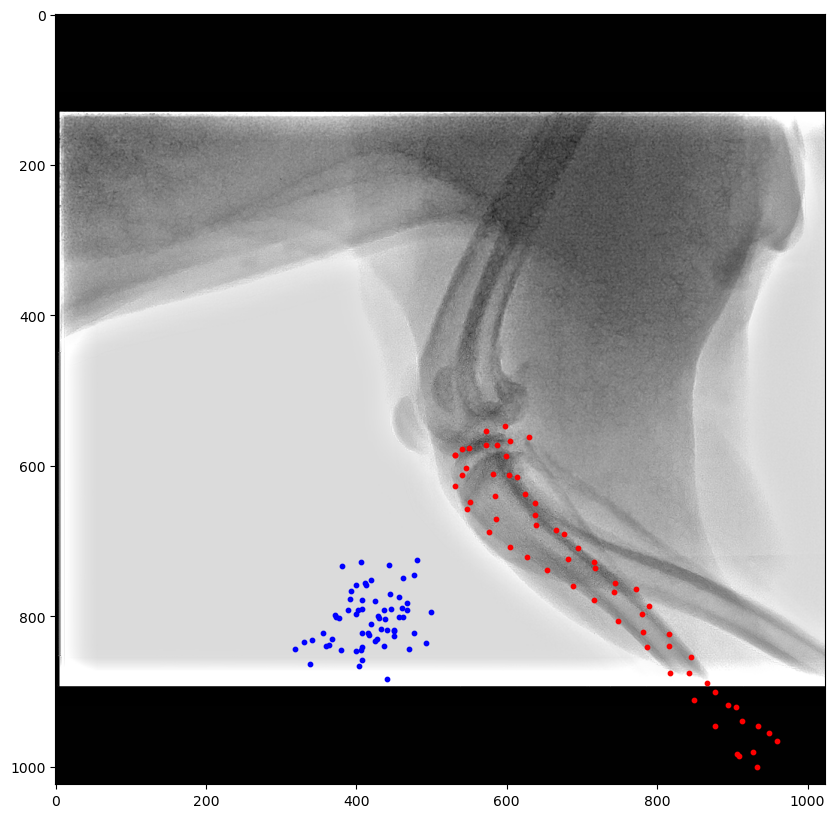

In [68]:
PRINT_DIR = '/media/sasank/LinuxStorage/Dropbox (UFL)/Canine Kinematics Data/image_check/albumentations/'
# Iterate through the csv keypoints on top of the images
CSV_FILE = '/home/sasank/Documents/GitRepos/PnP-Solver/kp_estimates/naive_predicted_R152_alb.csv'
data = pd.read_csv(CSV_FILE)

# Iterate through data
for idx, row in data.iterrows():
    print('idx: ', idx)
    # Get the image name
    image_name = row['Image address']

    # Get the image
    image = io.imread(os.path.join(config.datamodule['IMAGE_DIRECTORY'], image_name))

    # Process the image
    #image = np.transpose(image, (2, 0, 1))  # Transpose the image so that it's the same way as img
    image = np.dstack((image, image, image))    # Make it 3 channels
    """
        img = images.numpy()
        img = np.transpose(img, (1, 2, 0))  # Transpose the output so that it's the same way as img
        img = np.dstack((img, img, img))    # Make it 3 channels
        ax[0][0].imshow((img * 255).astype(np.uint8))  # The multiplying by 255 and stuff is so it doesn't get clipped or something
    """

    # Get the keypoint labels and segmentation labels
    if config.dataset['MODEL_TYPE'] == 'fem':
        kp_label = row['Femur 2D KP points']
        seg_label = io.imread(os.path.join(config.datamodule['IMAGE_DIRECTORY'], row['Fem label address']))
    elif config.dataset['MODEL_TYPE'] == 'tib':
        kp_label = row['Tibia 2D KP points']
        seg_label = io.imread(os.path.join(config.datamodule['IMAGE_DIRECTORY'], row['Tib label address']))
    else:
        raise Exception('Incorrect model type! Must be either \'fem\' or \'tib\'.')

    kp_label = kp_label[2:-2]
    kp_label = kp_label.split(']\n [')
    kp_label = [np.array([float(x) for x in list(filter(None, kp.split(' ')))]) for kp in kp_label]
    kp_label = np.array(kp_label)
    kp_label[:, 1] = 1 - kp_label[:, 1]         # ! New kp_label preprocessing
    kp_label = kp_label * 1024

    if config.dataset['MODEL_TYPE'] == 'fem':
        kp_preds = row['Femur PR KP points']
    elif config.dataset['MODEL_TYPE'] == 'tib':
        kp_preds = row['Tibia PR KP points']

    kp_preds = kp_preds[2:-2]
    kp_preds = kp_preds.split(']\n [')
    kp_preds = [np.array([float(x) for x in list(filter(None, kp.split(' ')))]) for kp in kp_preds]
    kp_preds = np.array(kp_preds)
    kp_preds[:, 1] = 1 - kp_preds[:, 1]         # ! New kp_label preprocessing
    kp_preds = kp_preds * 1024
    print('kp_preds: ', kp_preds)

    # * Plot the image
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    ax.scatter(kp_label[:, 0], kp_label[:, 1], c='r', s=10)
    ax.scatter(kp_preds[:, 0], kp_preds[:, 1], c='b', s=10)
    plt.savefig(os.path.join(PRINT_DIR, image_name))
    plt.close()



In [ ]:

    # * Transformations
    # Albumenations
    print('kp_label: ', kp_label)
    if config.dataset['USE_ALBUMENTATIONS'] == True:
        transformed = dataset.transform(image=image, mask=seg_label, keypoints=kp_label)
        image, seg_label, kp_label = transformed['image'], transformed['mask'], transformed['keypoints']
    print('transformed kp_label: ', kp_label)

    # * Subset Pixels
    full_image = image             # Save full image (no subset_pixels) for visualization
    if config.dataset['SUBSET_PIXELS'] == True:
        label_dst = np.zeros_like(seg_label)
        label_normed = cv2.normalize(seg_label, label_dst, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX)
        seg_label = label_normed

        kernel = np.ones((30,30), np.uint8)
        label_dilated = cv2.dilate(seg_label, kernel, iterations = 5)
        image_subsetted = cv2.multiply(label_dilated, image)


for i in range(len(dataset)):
    print("image number: " + str(i))
    batch = dataset[i]
    images = batch['image']
    kp_labels = batch['kp_label']
    img_names = batch['img_name']
    title = ''




    num_images = images.shape[0]
    num_keypoints = kp_labels.shape[0]
    assert num_keypoints == 64, "Number of keypoints is incorrect!"
    images = images.cpu()
    kp_labels = kp_labels.cpu()
    kp_labels = kp_labels.numpy()

    output_image_vector = []

    for i in range(0, num_images):
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), squeeze=False)

        # ! TODO: Is this the right way to do this? Is there something wrong here with offsets or something?
        #kp_labels[i][:, 0] = +1 * kp_labels[i][:, 0] * 1024
        #kp_labels[:, 0] = +1 * kp_labels[:, 0] * 1024
        #kp_labels[i][:, 1] = -1 * kp_labels[i][:, 1] * 1024 + 1024
        #kp_labels[:, 1] = -1 * kp_labels[:, 1] * 1024 + 1024
        # Do some stuff so that img is shown correctly
        img = images.numpy()
        img = np.transpose(img, (1, 2, 0))  # Transpose the output so that it's the same way as img
        img = np.dstack((img, img, img))    # Make it 3 channels
        ax[0][0].imshow((img * 255).astype(np.uint8))  # The multiplying by 255 and stuff is so it doesn't get clipped or something

        for j in range(num_keypoints):
            #ax[0][0].text(labels[i][j, 0], labels[i][j, 1], str(j), color='m')        # Silenced this for now since we have 64 keypoints
            ax[0][0].plot(kp_labels[j, 0], kp_labels[j, 1], color='orange', marker='.', markersize=5)
            #ax[0][0].plot([kp_labels[i][j, 0], kp_preds[i][j, 0]], [labels[i][j, 1], preds[i][j, 1]], color='limegreen', linestyle='-')
        image_name = img_names.split('/')[-1]    # Format img_names[i] so that only the part after the last '/' is shown
        ax[0][0].set_title(title + ' {}'.format(image_name))
        fig.savefig(os.path.join(PRINT_DIR, image_name))
        output_image_vector.append(fig)
        plt.close()
    